In [2]:
import os
import sys
import importlib
import moten
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

print(sys.path)
%pwd

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from classes.voxelsieve import VoxelSieve
from classes.natspatpred import NatSpatPred
NSP = NatSpatPred()
NSP.initialise()

# file_exists = os.path.isfile(f"{NSP.own_datapath}/visfeats/gabor_pyramid/gauss_checker_output.npy")


['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsd_access-0.0.1.dev0-py3.11.egg', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/cifti-1.1-py3.11.egg']
Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


In [3]:
rois, roi_masks, viscortex_mask = NSP.cortex.visrois_dict(verbose=False)
prf_dict = NSP.cortex.prf_dict(rois, roi_masks)

In [4]:
subject = "subj01"
max_size = 2
min_size = .15
patchbound = 1
min_nsd_R2 = 0
min_prf_R2 = 0
# fixed_n_voxels = 170
voxeldict = {}
n_voxels = []

peri_angle=90 # 90, 210, 330
peri_ecc=2.0


for roi in rois:
    while True:
        print_attr = True if roi == rois[len(rois) - 1] else False
        voxeldict[roi] = VoxelSieve(
            NSP,
            prf_dict,
            roi_masks,
            subject=subject,
            roi=roi,
            patchloc="peripheral",
            max_size=max_size,
            min_size=min_size,
            patchbound=patchbound,
            min_nsd_R2=min_nsd_R2,
            min_prf_R2=min_prf_R2,
            print_attributes=False, 
            fixed_n_voxels=None,
            peripheral_center=None,
            peri_angle=peri_angle,
            peri_ecc=peri_ecc,
            leniency = 0.25,
            verbose=False
        )
        if len(voxeldict[roi].size) > 0:
            break
        else:
            patchbound += 0.1
            print(f"No voxels found for ROI {roi} with patchbound {patchbound - 0.1}. Trying with patchbound {patchbound}.")
    n_voxels.append(len(voxeldict[roi].size))


V1 voxels that fulfill requirements: 71 out of 7887.
V2 voxels that fulfill requirements: 89 out of 8296.
V3 voxels that fulfill requirements: 18 out of 7022.
V4 voxels that fulfill requirements: 15 out of 3976.


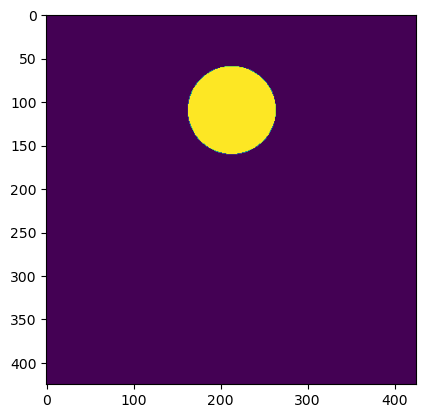

In [121]:
plt.imshow(voxeldict["V1"].patchmask)

In [6]:
from funcs.gaborpyr import (
    isotropic_gaussian,
    circle_stim,
    random_dot,
    show,
    cut_corners,
    make_checker,
    plot_filter_locations,
    plot_filter_outputs,
    normalize_output,
)

(-3.6739403974420594e-16, -2.0)
(0, -101)


In [8]:
def make_checker(dims, checkercenter, scales, scaling_factor, checker_size, stride):
    """
    Create a checkerboard pattern with optional scaling and centering.

    Args:
        dims (tuple): The dimensions of the checkerboard.
        checkercenter (tuple): The center coordinates of the checkerboard.
        scales (int): The number of scales for the checkerboard.
        scaling_factor (float): The scaling factor for each scale.
        checker_size (int): The size of each checkerboard square.
        stride (int): The stride for the smaller checkerboard.

    Returns:
        numpy.ndarray: The generated checkerboard pattern.
    """
    
    if scales == 0:
        # Create a full checkerboard of the given dimensions and checker size
        checkerboard = np.indices(dims).sum(axis=0) % 2
        checkerboard = np.repeat(checkerboard, checker_size, axis=0)
        checkerboard = np.repeat(checkerboard, checker_size, axis=1)
        checkerboard = checkerboard[:dims[0], :dims[1]].astype(float)
        return checkerboard
    else:
        # Create a checkerboard of the current scale
        checkerboard = np.indices(dims).sum(axis=0) % 2
        checkerboard = np.repeat(checkerboard, checker_size, axis=0)
        checkerboard = np.repeat(checkerboard, checker_size, axis=1)
        checkerboard = checkerboard[:dims[0], :dims[1]].astype(float)

        # Create a smaller checkerboard in the center
        smaller_dims = (int((dims[0] - 2 * stride) / scaling_factor), int((dims[1] - 2 * stride) / scaling_factor))
        smaller_checker_size = int(checker_size / scaling_factor)
        smaller_checkerboard = make_checker(smaller_dims, checkercenter, scales - 1, scaling_factor, smaller_checker_size, stride)

        # Replace the section of the larger checkerboard with the smaller one
        start = (dims[0] // 2 - smaller_dims[0] // 2, dims[1] // 2 - smaller_dims[1] // 2)
        checkerboard[start[0] + stride:start[0] + smaller_dims[0] + stride, start[1] + stride:start[1] + smaller_dims[1] + stride] = smaller_checkerboard

        return checkerboard

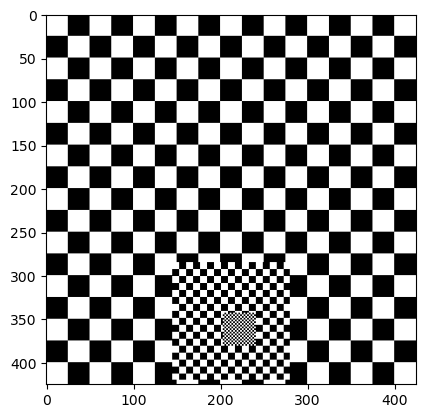

In [23]:
dims = (425,425); checker_size = 25; scaling_factor=3; stride=10; checkercenter=(212,212); scales=2
# Create a full checkerboard of the given dimensions and checker size
checkerboard = np.indices(dims).sum(axis=0) % 2
checkerboard = np.repeat(checkerboard, checker_size, axis=0)
checkerboard = np.repeat(checkerboard, checker_size, axis=1)
checkerboard = checkerboard[:dims[0], :dims[1]].astype(float)

# Create a smaller checkerboard in the center
smaller_dims = (int((dims[0] - 2 * stride) / scaling_factor), int((dims[1] - 2 * stride) / scaling_factor))
smaller_checker_size = int(checker_size / scaling_factor)
smaller_checkerboard = make_checker(smaller_dims, checkercenter, scales - 1, scaling_factor, smaller_checker_size, stride)

h_stride = 0
v_stride = 140

# Replace the section of the larger checkerboard with the smaller one
start = (dims[0] // 2 - smaller_dims[0] // 2, dims[1] // 2 - smaller_dims[1] // 2)
checkerboard[start[0] + v_stride:start[0] + smaller_dims[0] + v_stride, start[1] + h_stride:start[1] + smaller_dims[1] + h_stride] = smaller_checkerboard


plt.imshow(checkerboard, cmap="binary")

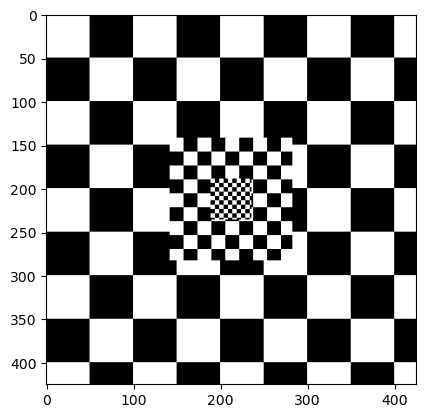

In [29]:
checker_stim = make_checker(
    dims=(425, 425),
    checkercenter=(212, 212),
    # checkercenter=(100, 212),
    scales=2,
    scaling_factor=3,
    checker_size=50,
    stride=0,
)

plt.imshow(checker_stim, cmap="binary")

In [ ]:
def _get_peri_bounds(
    self,
    patchbound: float,
    peripheral_center: tuple|None,
    peri_angle: float|None,
    peri_ecc: float|None,
    leniency: float = 0.0,
    verbose: bool = True,
):
    # Convert angles from degrees to radians
    peri_angle_rad = np.deg2rad(peri_angle)

    # Convert polar coordinates to Cartesian coordinates
    peri_x = peri_ecc * np.cos(peri_angle_rad)
    peri_y = peri_ecc * np.sin(peri_angle_rad)
    peripheral_center = (peri_x, peri_y)

    # Compute the distance from each voxel to the center of the patch
    voxel_x = self.ecc * np.cos(np.deg2rad(self.angle))
    voxel_y = self.ecc * np.sin(np.deg2rad(self.angle))
    distances = np.sqrt(
        (voxel_x - peripheral_center[0]) ** 2 + (voxel_y - peripheral_center[1]) ** 2
    )

    # Select the voxels for which the distance plus the size times (1 - leniency) is less than or equal to the patchbound
    selected_voxels = distances + self.size * (1 - leniency) <= patchbound

    return selected_voxels

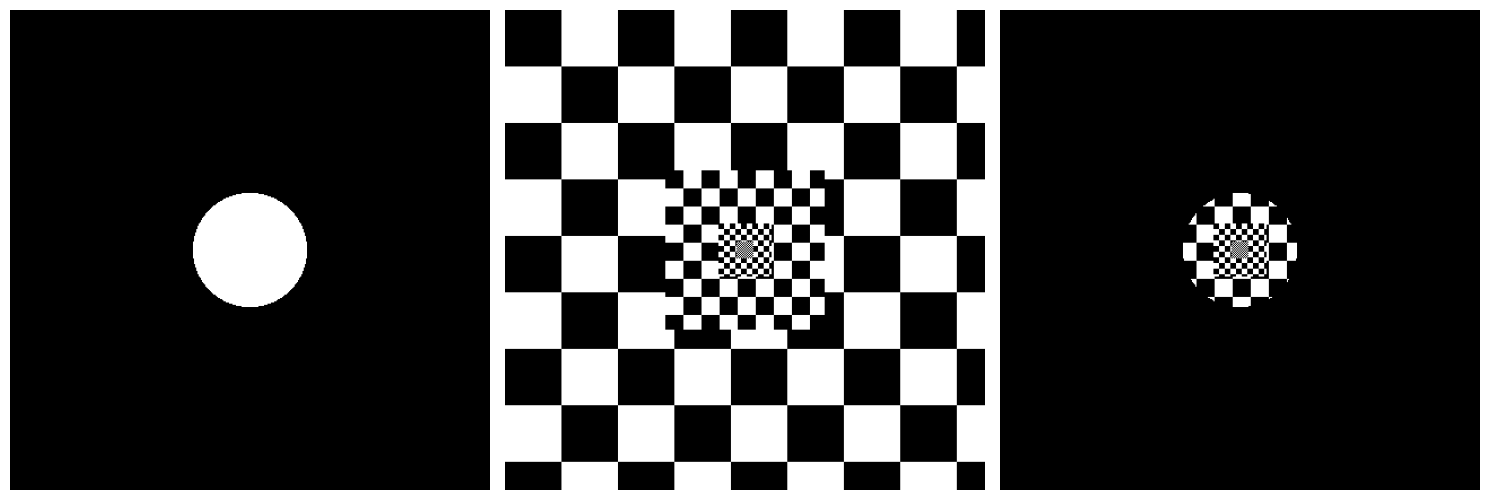

In [26]:
pixels = 425
degrees = 8.4
pix_per_deg = pixels / degrees

cirkel = circle_stim((425, 425), (1 * pix_per_deg), (212, 212))

checker_stim = make_checker(
    dims=(425, 425),
    # checkercenter=(212, 212),
    checkercenter=(100, 212),
    scales=3,
    scaling_factor=3,
    checker_size=50,
    stride=0,
)


fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for img_no, img in enumerate([cirkel, checker_stim, checker_stim * cirkel]):
    axes[img_no].imshow(img, cmap="gist_gray")
    axes[img_no].axis("off")
plt.tight_layout()

circ_check_stack = np.stack([cirkel, checker_stim * cirkel], axis=0)

### Turn into function

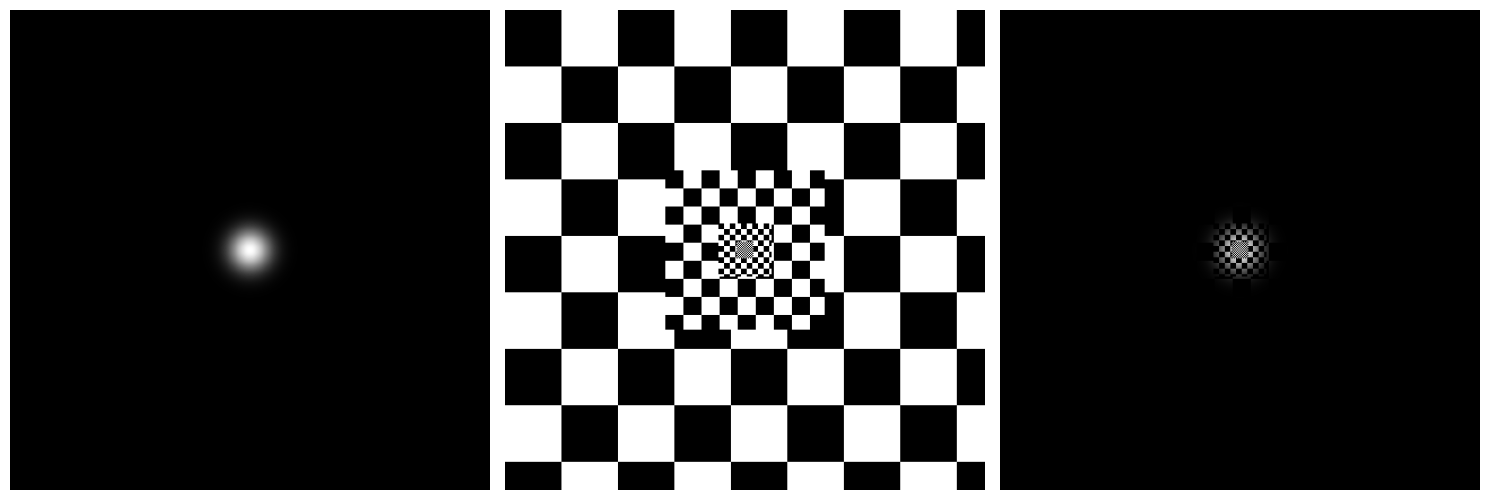

In [108]:
gauss = isotropic_gaussian(dims=(425,425), sigma=pix_per_deg/4) # Justify this 2.5 factor

checker_stim = make_checker(dims=(425,425), checkercenter=(212,212), scales=3, scaling_factor=3, checker_size=50, stride=0)

fig, axes = plt.subplots(1, 3, figsize=(15,6))

for img_no, img in enumerate([gauss, checker_stim, checker_stim * gauss]):
    axes[img_no].imshow(img, cmap='gist_gray')
    axes[img_no].axis("off")
plt.tight_layout()

gauss_check_stack = np.stack([gauss, checker_stim * gauss], axis=0)


The desired patch location has: 2.0 degrees eccentricity at 210 degrees polar angle at coordinates (-1.73, -1.0).
Which requires the patch center to be shifted -87 pixels horizontally and -50 pixels vertically.


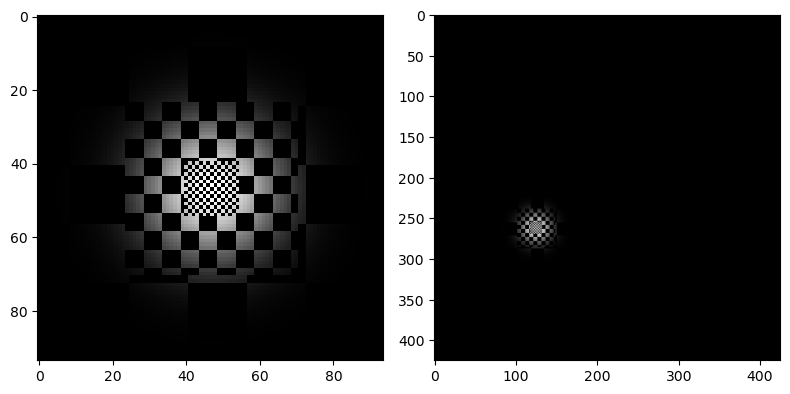

In [205]:
#### REQUIRES AS INPUT A TUPLE WITH THE CHECKERED PATCH AND ITS GAUSSIAN COMPAGNON


def cut_paste_mask(
    masks: np.ndarray,
    peri_angle: int,
    peri_ecc: float,
    pix_per_deg: float = (425 / 8.4),
    verbose: bool = False,
    plot: bool = False,
) -> np.ndarray:
    # Convert angles from degrees to radians
    peri_angle_rad = np.deg2rad(peri_angle)
    # Convert polar coordinates to Cartesian coordinates
    peri_x = peri_ecc * np.cos(peri_angle_rad)
    peri_y = peri_ecc * np.sin(peri_angle_rad)
    peripheral_center = (peri_x, peri_y)

    # Convert Cartesian coordinates to pixel coordinates
    peripheral_center_pix = tuple(
        [int(pixloc * pix_per_deg) for pixloc in peripheral_center]
    )
    if verbose:
        print(
            f"The desired patch location has: {peri_ecc} degrees eccentricity at {peri_angle} degrees polar angle at coordinates {(round(peripheral_center[0],2), round(peripheral_center[1],2))}."
        )
        print(
            f"Which requires the patch center to be shifted {peripheral_center_pix[0]} pixels horizontally and {peripheral_center_pix[1]} pixels vertically."
        )

    gauss_area = np.array(gauss > 0.001).reshape(masks[0].shape)
    cut_ices = NSP.utils.get_bounding_box(gauss_area)

    check_patch = gauss_check_stack[1][
        cut_ices[0] : cut_ices[1], cut_ices[2] : cut_ices[3]
    ]

    peri_patch = np.zeros_like(gauss)

    row_shift = peripheral_center_pix[1]
    col_shift = peripheral_center_pix[0]

    peri_patch[
        cut_ices[0] - row_shift : cut_ices[1] - row_shift,
        cut_ices[2] + col_shift : cut_ices[3] + col_shift,
    ] = check_patch


    if plot:
        _, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(check_patch, cmap="gist_gray")
        axes[1].imshow(peri_patch, cmap="gist_gray")
        plt.tight_layout()
        
    return peri_patch
    
_ = cut_paste_mask(gauss_check_stack, 210, 2.0, verbose=True, plot=True)

In [157]:
# USE THIS CONVERSION AND TRY TO SHIFT THE CENTER OF THE GABOR FILTERS
# PERHAPS USING THE STRIDE THING, AS THAT'S CAPABLE OF SHIFTING THE FILTER LOCS

peri_angle = 210; peri_ecc = 2.0

# Convert angles from degrees to radians
peri_angle_rad = np.deg2rad(peri_angle)
pixperdeg = 425/8.4
# Convert polar coordinates to Cartesian coordinates
peri_x = peri_ecc * np.cos(peri_angle_rad)
peri_y = peri_ecc * np.sin(peri_angle_rad)
peripheral_center = (peri_x, peri_y)
print(peripheral_center)

# Convert Cartesian coordinates to pixel coordinates
peripheral_center_pix = tuple([int(pixloc * pixperdeg) for pixloc in peripheral_center])
print(peripheral_center_pix)


(-1.7320508075688772, -1.0000000000000002)
(-87, -50)


In [187]:
gauss_area = np.array(gauss > .001).reshape(cirkel.shape)
cut_ices = NSP.utils.get_bounding_box(gauss_area)

peripheral_center_pix 

(-87, -50)

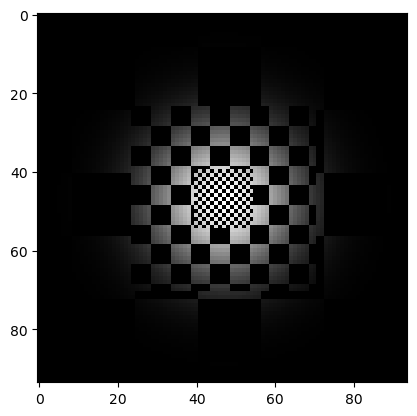

In [188]:
check_patch = gauss_check_stack[1][cut_ices[0]:cut_ices[1], cut_ices[2]:cut_ices[3]]
plt.imshow(check_patch, cmap="gist_gray")

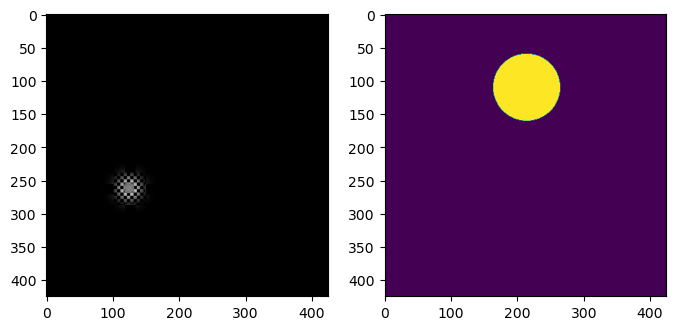

In [160]:
peri_patch = np.zeros_like(gauss)

row_shift = peripheral_center_pix[1]
col_shift = peripheral_center_pix[0]

peri_patch[
    cut_ices[0] - row_shift : cut_ices[1] - row_shift,
    cut_ices[2] + col_shift : cut_ices[3] + col_shift,
] = check_patch


fig, axes = plt.subplots(1, 2, figsize=(8, 6))
axes[0].imshow(peri_patch, cmap="gist_gray")
# plt.imshow(np.zeros_like(gauss), cmap="RdGy")

axes[1].imshow(voxeldict["V1"].patchmask)

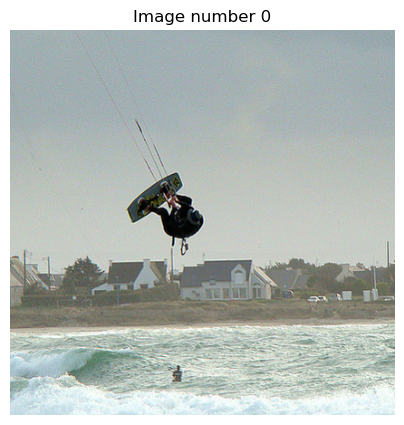

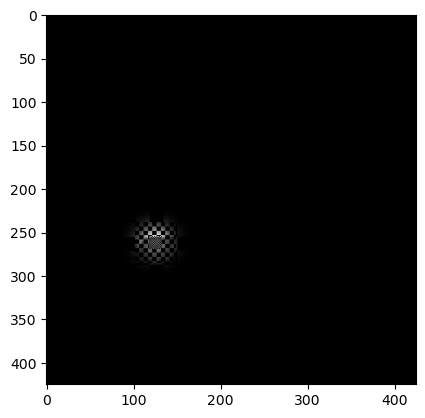

In [161]:
img = NSP.stimuli.show_stim(0, small=True)[0]


# plt.imshow(img[:,:,0] * voxeldict["V1"].patchmask, cmap="gray")
plt.imshow(img[:,:,0] * peri_patch, cmap="gray")

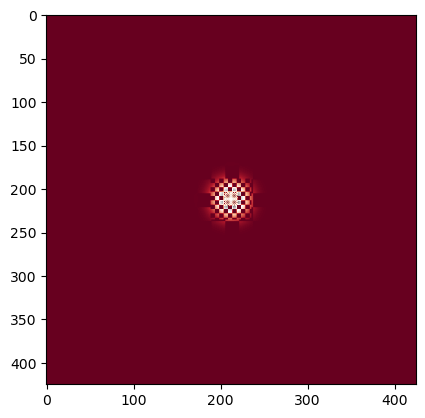

In [67]:
plt.imshow(gauss_check_stack[1], cmap="RdGy")